In [1]:

# Turn off Pretty Print, enable inline plotting with Matplotlib, add py folder to system path, import jobpostlib modules
%pprint
%matplotlib inline
import sys
if ('../py' not in sys.path): 
    sys.path.insert(1, '../py')
from jobpostlib import (
    crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, 
    scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine
)
from pandas import DataFrame
from tqdm import tqdm

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 8 seconds


In [2]:

# Check if the slrcu object has the attribute 'pos_predict_percent_fit_dict'
# If not, build the parts-of-speech logistic regression elements
# Parts-of-speech logistic regression elements is normally built in 1 hour, 27 minutes and 21 seconds
t1 = time.time()
if not hasattr(slrcu, 'pos_predict_percent_fit_dict'):
    slrcu.build_pos_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
if hasattr(slrcu, 'pos_predict_percent_fit_dict'): print('predict_single is available')
else: print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Parts-of-speech logistic regression elements built in {duration_str}'; print(speech_str)

I have 48,494 labeled parts of speech in here


Train the POS Classifier: 100%|███████████████████████████████████████████████████████| 26/26 [00:00<00:00, 418.27it/s]

predict_single is available
Parts-of-speech logistic regression elements built in 6 seconds



## Let's test the accuracy of our Logistic Regression Navigable Parent Classifier

In [3]:

# Get the value counts of the labeled POS symbols
cypher_str = """
    MATCH (pos:PartsOfSpeech)-[r:SUMMARIZES]->(np:NavigableParents)
    RETURN
        np.navigable_parent AS navigable_parent, 
        pos.pos_symbol AS pos_symbol;"""
pos_df = DataFrame(cu.get_execution_results(cypher_str, verbose=False))
value_counts_srs = pos_df.value_counts('pos_symbol')
print(f"{value_counts_srs.sum():,}")
display(value_counts_srs)

48,494


pos_symbol
O-RQ    17480
O-JT     9906
O-TS     7028
O-IP     4970
O-PQ     2289
H-RQ     1287
O-CS      889
O-SP      641
O-JD      609
H-TS      565
H-PQ      426
O-ER      365
H-CS      334
O-PD      300
O-OL      245
H-SP      186
O-O       177
O-LN      151
H-O       144
H-IP      140
H-OL       95
H-JT       86
H-LN       72
H-ER       70
H-JD       34
H-PD        5
Name: count, dtype: int64

In [4]:

# Record the current time to measure the duration of the process and check if the true and predicted labels for the logistic regression model already exist
t1 = time.time()
if all(map(lambda x: nu.pickle_exists(x), ['slrcu_pos_logistic_regression_sents_list', 'slrcu_pos_logistic_regression_trues_list', 'slrcu_pos_logistic_regression_preds_list'])):
    
    # Load the existing sents, true and predicted labels
    sents_list = nu.load_object('slrcu_pos_logistic_regression_sents_list')
    y_true = nu.load_object('slrcu_pos_logistic_regression_trues_list')
    y_pred = nu.load_object('slrcu_pos_logistic_regression_preds_list')
    
else:
    
    # Initialize empty lists to store true and predicted labels
    sents_list = []
    y_true = []
    y_pred = []
    
    # Group the DataFrame by 'navigable_parent' and 'pos_symbol'
    pos_df_groupby = pos_df.groupby(['navigable_parent', 'pos_symbol'])
    
    # Create a progress bar for the prediction process
    progress_bar = tqdm(
        pos_df_groupby, total=len(pos_df_groupby), desc="Predict Label"
    )
    
    # Iterate through each group in the DataFrame
    for (sent_str, pos_symbol), _ in progress_bar:
        
        # Append the sent_str to the list
        sents_list.append(sent_str)
        
        # Append the true label (POS symbol) to the list
        y_true.append(pos_symbol)
        
        # Predict the POS symbol for the given sentence string
        prediction = slrcu.predict_single(sent_str)
        
        # Append the predicted label to the list
        y_pred.append(prediction)
    
    # Store sents, true and predicted labels for future use
    nu.store_objects(slrcu_pos_logistic_regression_sents_list=sents_list, slrcu_pos_logistic_regression_trues_list=y_true, slrcu_pos_logistic_regression_preds_list=y_pred, verbose=False)
    
# Calculate the duration of the process and convert it to a human-readable format
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')

# Create a speech string to announce the completion of the evaluation and use the speech engine to announce the completion of the evaluation
speech_str = f'Parts-of-speech logistic regression classifier evaluated in {duration_str}'; speech_engine.say(speech_str); speech_engine.runAndWait()

Predict Label: 100%|███████████████████████████████████████████████████████████| 48492/48492 [3:12:39<00:00,  4.19it/s]


In [5]:

# Evaluate the performance of the model based on the classification report below:
from sklearn.metrics import classification_report

# Generate a classification report based on the true and predicted labels
classification_report_str = classification_report(y_true, y_pred)

# Print the classification report
print(classification_report_str)

              precision    recall  f1-score   support

        H-CS       0.98      0.98      0.98       334
        H-ER       0.88      1.00      0.93        70
        H-IP       0.82      0.92      0.87       140
        H-JD       0.92      1.00      0.96        34
        H-JT       0.91      1.00      0.95        86
        H-LN       0.95      1.00      0.97        72
         H-O       0.90      0.88      0.89       144
        H-OL       0.90      1.00      0.95        95
        H-PD       1.00      1.00      1.00         5
        H-PQ       0.96      0.98      0.97       426
        H-RQ       0.99      0.97      0.98      1287
        H-SP       0.99      1.00      0.99       186
        H-TS       0.98      0.97      0.97       565
        O-CS       0.97      0.99      0.98       889
        O-ER       0.95      1.00      0.97       365
        O-IP       1.00      0.99      0.99      4970
        O-JD       0.99      0.99      0.99       609
        O-JT       1.00    


The classification report provides a comprehensive evaluation of the model's performance. Here's a breakdown of the key metrics:

**Precision:** This measures the proportion of correct positive predictions out of all positive predictions. A high precision indicates that the model is good at identifying positive instances.

**Recall:** This measures the proportion of correct positive predictions out of all actual positive instances. A high recall indicates that the model is good at capturing all positive instances.

**F1-score:** This is the harmonic mean of precision and recall, providing a balanced measure of both. A high F1-score indicates that the model is good at both precision and recall.

**Support:** This indicates the number of instances for each class.

**Accuracy:** This measures the overall proportion of correct predictions out of all instances.

**Macro average:** This calculates the average of precision, recall, and F1-score across all classes, giving equal weight to each class.

**Weighted average:** This calculates the average of precision, recall, and F1-score across all classes, weighting each class by its support.

**Overall, based on the report, the model is performing very well:**

* **High accuracy:** The overall accuracy of 0.99 indicates that the model is correctly classifying a very high percentage of instances.
* **High precision and recall:** Most classes have precision and recall values close to 1.0, indicating that the model is both identifying positive instances accurately and capturing most of the actual positive instances.
* **High F1-score:** The F1-score for most classes is also close to 1.0, confirming the model's strong performance in terms of both precision and recall.

**However, there are a few classes with slightly lower performance:**

* **H-ER, H-IP, H-LN, O-LN, O-OL:** These classes have lower precision and F1-score values, suggesting that the model might be making more errors in predicting these classes.

Overall, the model demonstrates excellent performance, but further investigation into the classes with lower performance could help identify potental areas for improvement.


In [9]:

# Add the predicted parts of speech to the POS dataframe
t1 = time.time()
if nu.pickle_exists('slrcu_pos_logistic_regression_df'):
    
    # Load the existing true and predicted labels
    pos_df = nu.load_object('slrcu_pos_logistic_regression_df')
    
else:
    
    # Group the DataFrame by 'navigable_parent' and 'pos_symbol'
    pos_df_groupby = pos_df.groupby(['navigable_parent', 'pos_symbol'])
    
    # Create a progress bar for the prediction process
    progress_bar = tqdm(
        pos_df_groupby, total=len(pos_df_groupby), desc="Add y_pred column"
    )
    
    # Iterate through each group in the DataFrame
    for i, ((sent_str, pos_symbol), df) in enumerate(progress_bar):
        mask_series = (pos_df.navigable_parent == sent_str) & (pos_df.pos_symbol == pos_symbol)
        pos_df.loc[mask_series, 'y_pred'] = y_pred[i]
    
    nu.store_objects(slrcu_pos_logistic_regression_df=pos_df, verbose=False)
    
# Calculate the duration of the process and convert it to a human-readable format
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')

# Create a speech string to announce the completion of the evaluation and use the speech engine to announce the completion of the evaluation
speech_str = f'Predicted parts-of-speech column added in {duration_str}'; speech_engine.say(speech_str); speech_engine.runAndWait()

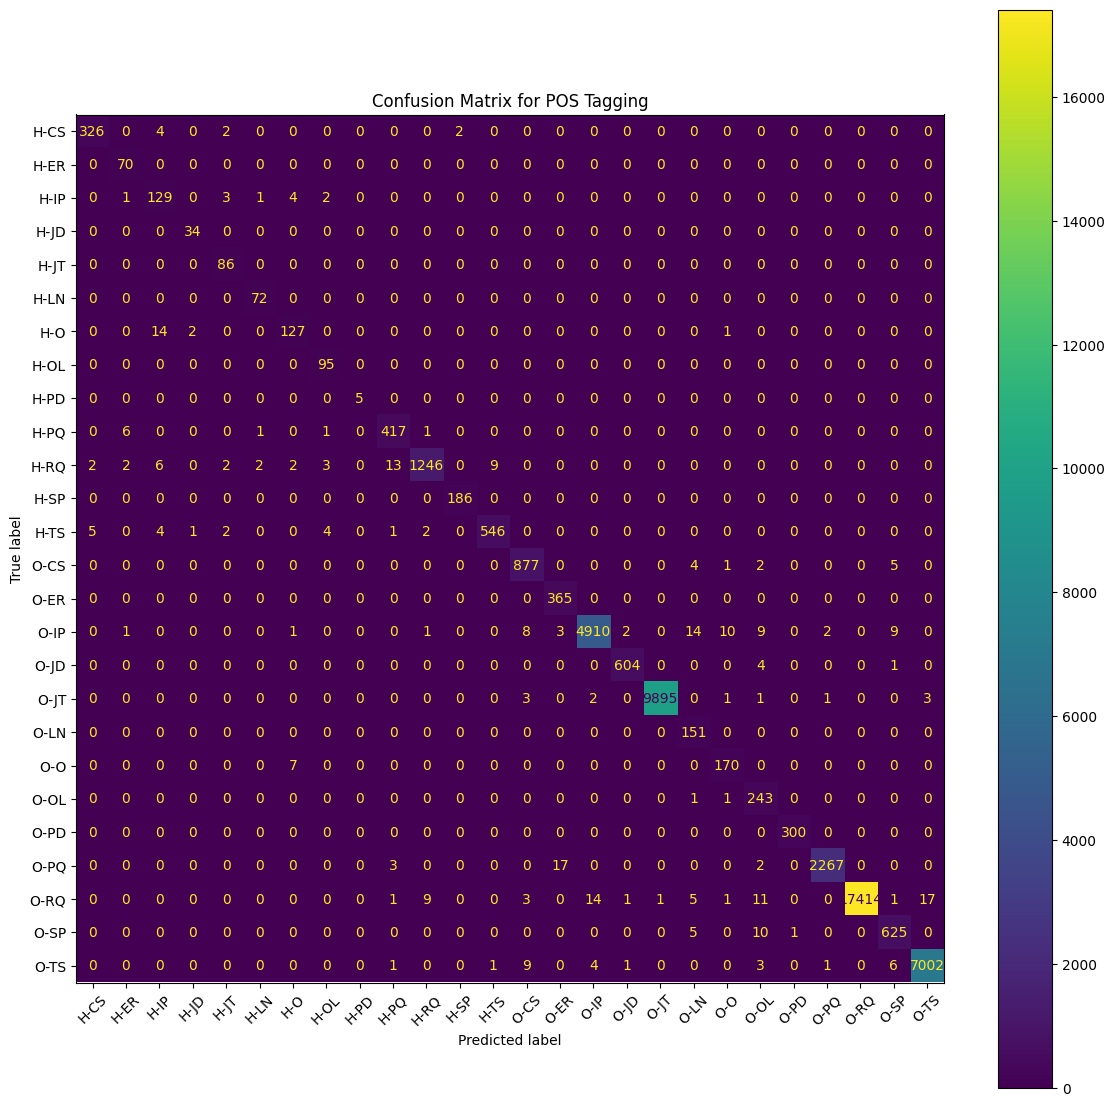

In [8]:

# Import the necessary functions and libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Generate the confusion matrix based on the true and predicted labels
cm = confusion_matrix(y_true, y_pred)

# Create a ConfusionMatrixDisplay object with the confusion matrix and display labels
cmd = ConfusionMatrixDisplay(cm, display_labels=[row_str.strip().split()[0] for row_str in classification_report_str.split('\n')[2:-5]])

# Create a figure and axis for the plot with a specified size
fig, ax = plt.subplots(figsize=(14, 14))

# Set the title and labels for the plot
plt.title("Confusion Matrix for POS Tagging")
plt.xlabel("Predicted POS Label")
plt.ylabel("True POS Label")

# Plot the confusion matrix with a logarithmic color scale
im = ax.imshow(cm, interpolation='nearest', cmap='viridis', norm=mcolors.LogNorm(vmin=cm.min() + 1, vmax=cm.max()))
# plt.colorbar(im, ax=ax)

# Plot the confusion matrix display over the imshow plot
ConfusionMatrixDisplay_obj = cmd.plot(ax=ax, xticks_rotation=45, cmap='viridis')

# Show the plot
plt.show()


# Maintenance

In [ ]:
raise

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Fit-transform the Bag-of-words from these hand-labeled HTML strings
sents_list = pos_df.navigable_parent.tolist()
pos_symbols_list = pos_df.pos_symbol.tolist()

# Learn the vocabulary dictionary
bow_matrix = slrcu.count_vect.fit_transform(sents_list)
print(bow_matrix.shape)

# Fit the TF-IDF transformer
X_tfidf = slrcu.tfidf_transformer.fit_transform(bow_matrix)
print(X_tfidf.shape)

# Define a function to fit the classifier
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, pos_symbols_list, random_state=0)
clf = LogisticRegression(
    C=375.0, class_weight='balanced', max_iter=1000, penalty='l1',
    solver='liblinear', verbose=False, warm_start=True
)
clf.fit(X_train, y_train)

(48508, 424274)
(48508, 424274)


LogisticRegression(C=375.0, class_weight='balanced', max_iter=1000,
                   penalty='l1', solver='liblinear', verbose=False,
                   warm_start=True)

TypeError: ConfusionMatrixDisplay.from_estimator() got an unexpected keyword argument 'norm'

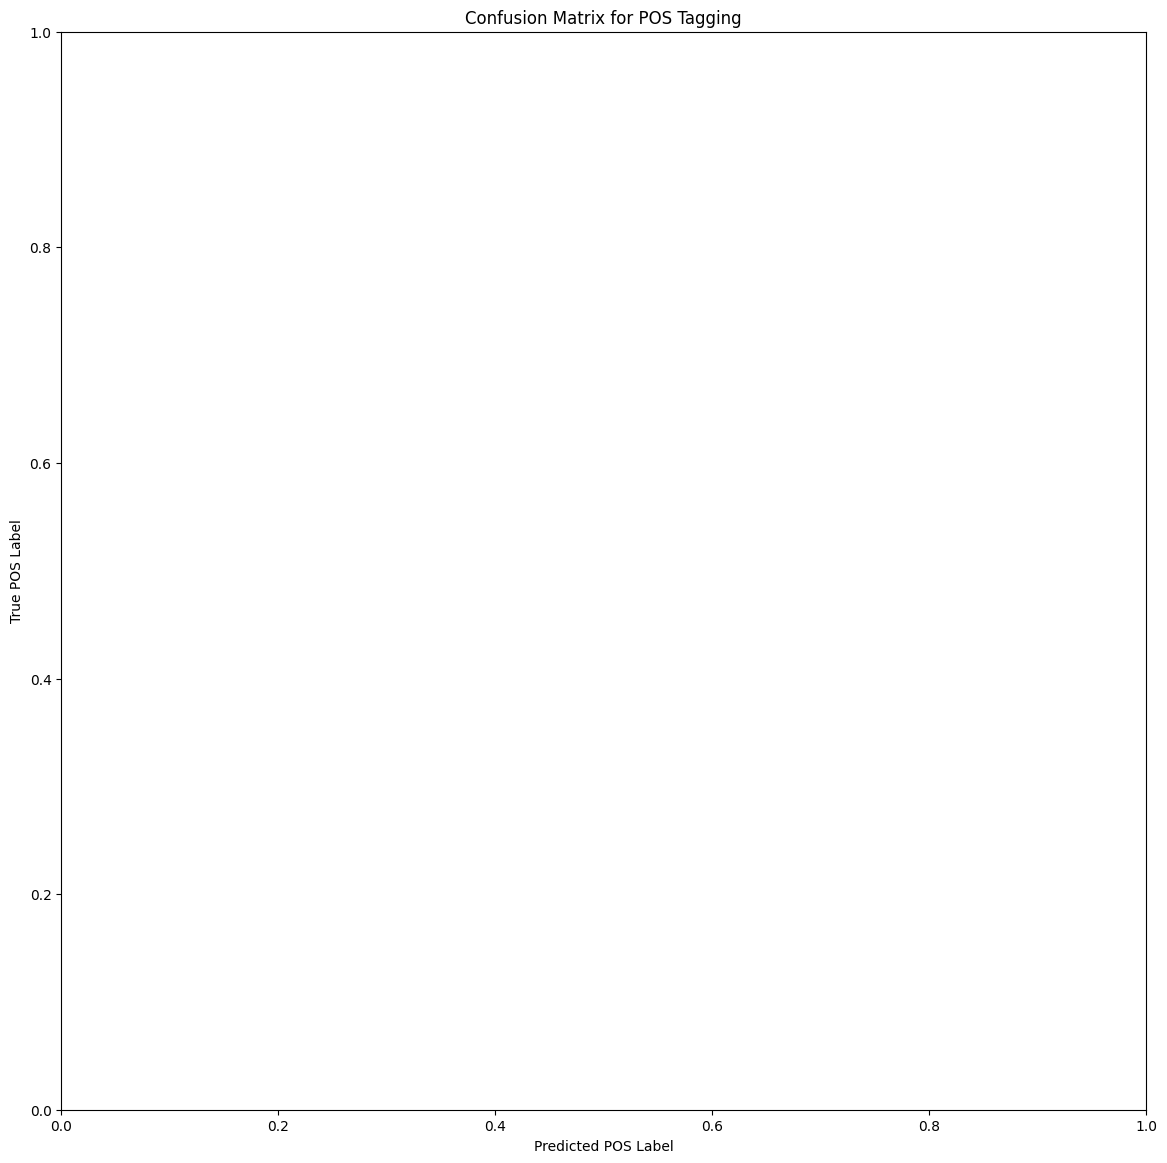

In [11]:

# Create a figure and axis for the plot with a specified size
fig, ax = plt.subplots(figsize=(14, 14))

# Set the title and labels for the plot
plt.title("Confusion Matrix for POS Tagging")
plt.xlabel("Predicted POS Label")
plt.ylabel("True POS Label")

# Plot the confusion matrix with rotated x-axis tick labels
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, xticks_rotation=45, cmap='viridis', norm=mcolors.LogNorm(vmin=cm.min() + 1, vmax=cm.max()))
plt.show()

In [ ]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
assert pos_df.columns.tolist() == ['navigable_parent', 'pos_symbol', 'y_pred'], "You've inadvertently added some columns"

In [ ]:

supposed_to_be = 'O-RQ'
predicted_to_be = 'O-OL'
mask_series = (pos_df.pos_symbol == supposed_to_be) & (pos_df.y_pred == predicted_to_be)
print(pos_df[mask_series].shape)
display(pos_df[mask_series])
child_strs_list = pos_df[mask_series].navigable_parent.unique().tolist()

In [ ]:

child_str = child_strs_list.pop()
child_str, len(child_strs_list)

In [ ]:

file_name = '66e80ba5abef9041_Senior_SDET_Senior_QA_Python_Sunnyvale_CA_94089_Indeed_com.html'
file_path = osp.abspath(osp.join(hau.SAVES_HTML_FOLDER, file_name))
wsu.clean_job_posting(file_path)
!"{text_editor_path}" "{file_path}"

In [ ]:

# Delete the child string from the database
from IPython.display import clear_output

def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = """
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        DETACH DELETE np;"""
    if verbose:
        clear_output(wait=True)
        print(cypher_str.replace('$navigable_parent', f'"{navigable_parent}"'))
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
with cu.driver.session() as session: session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=True)

In [ ]:

cu.rebuild_filename_node(file_name, navigable_parent=child_str, verbose=True)
speech_str = 'File name node rebuild completed'; speech_engine.say(speech_str); speech_engine.runAndWait()

In [ ]:

# Fix all the source POS symbols that should be target POS symbols
change_it_to = 'O-PQ'
def do_cypher_tx(tx, navigable_parent):
    
    # Delete any existing relationships
    cypher_str = '''
        // Find all our NavigableParents nodes in the graph with
        // an incoming SUMMARIZES relationship to any
        // PartsOfSpeech node and delete that relationship
        MATCH (np:NavigableParents)<-[r:SUMMARIZES]-(pos:PartsOfSpeech)
        WHERE (np.navigable_parent = $navigable_parent)
        DELETE r;'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    
    # Create a new relationship
    cypher_str = f'''
        // Create a new relationship with target pos_symbol
        MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
        MATCH (existing_pos:PartsOfSpeech {{pos_symbol: "{change_it_to}"}})
        CREATE (np)<-[:SUMMARIZES]-(existing_pos);'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    
    # Reset other subtypes
    cypher_str = f'''
        // Ensure that the other subtypes are reset to false
        MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
        SET
            np.is_header = {str(change_it_to.startswith('H-')).lower()},
            np.is_job_title = {str(change_it_to.endswith('-JT')).lower()},
            np.is_corporate_scope = {str(change_it_to.endswith('-CS')).lower()},
            np.is_task_scope = {str(change_it_to.endswith('-TS')).lower()},
            np.is_educational_requirement = {str(change_it_to.endswith('-ER')).lower()},
            np.is_minimum_qualification = {str(change_it_to.endswith('-RQ')).lower()},
            np.is_preferred_qualification = {str(change_it_to.endswith('-PQ')).lower()},
            np.is_supplemental_pay = {str(change_it_to.endswith('-SP')).lower()},
            np.is_office_location = {str(change_it_to.endswith('-OL')).lower()},
            np.is_job_duration = {str(change_it_to.endswith('-JD')).lower()},
            np.is_interview_procedure = {str(change_it_to.endswith('-IP')).lower()},
            np.is_legal_notification = {str(change_it_to.endswith('-LN')).lower()},
            np.is_other = {str(change_it_to.endswith('-O')).lower()},
            np.is_posting_date = {str(change_it_to.endswith('-PD')).lower()};'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})

mask_series = (pos_df.navigable_parent == child_str)
pos_df.loc[mask_series, 'pos_symbol'] = change_it_to
with cu.driver.session() as session: session.write_transaction(
    do_cypher_tx, navigable_parent=child_str
)

In [ ]:

mask_series = (pos_df.navigable_parent == child_str)
display(pos_df[mask_series])
pos_df.loc[mask_series, 'pos_symbol'] = 'O-ER'
def do_cypher_tx(tx, navigable_parent):
    
    # Delete the existing relationship
    cypher_str = '''
        // Find all our NavigableParents nodes in the graph with
        // an incoming SUMMARIZES relationship to any
        // PartsOfSpeech node and delete that relationship
        MATCH (np:NavigableParents)<-[r:SUMMARIZES]-(pos:PartsOfSpeech)
        WHERE (np.navigable_parent = $navigable_parent)
        DELETE r;'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    
    # Create a new relationship
    cypher_str = '''
        // Create a new relationship with pos_symbol "O-ER"
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        MATCH (existing_pos:PartsOfSpeech {pos_symbol: "O-ER"})
        CREATE (np)<-[:SUMMARIZES]-(existing_pos);'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    
    # Reset other subtypes
    cypher_str = '''
        // Ensure that the other subtypes are reset to false
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        SET
            np.is_header = false,
            np.is_job_title = false,
            np.is_corporate_scope = false,
            np.is_task_scope = false,
            np.is_educational_requirement = true,
            np.is_minimum_qualification = false,
            np.is_preferred_qualification = false,
            np.is_supplemental_pay = false,
            np.is_office_location = false,
            np.is_job_duration = false,
            np.is_interview_procedure = false,
            np.is_legal_notification = false,
            np.is_other = false,
            np.is_posting_date = false;'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})

with cu.driver.session() as session: session.write_transaction(
    do_cypher_tx, navigable_parent=child_str
)

In [ ]:

def do_cypher_tx(tx, navigable_parent):
    
    # Find badly created relationships
    cypher_str = '''
        // Find all our PartsOfSpeech nodes in the graph with
        // bad POS explanations
        MATCH (pos:PartsOfSpeech)
        WHERE pos.pos_explanation IS NULL
        RETURN
            pos.pos_symbol AS pos_symbol,
            pos.pos_explanation AS pos_explanation;'''
    tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})

In [ ]:

# Convert these qualifications into a list of skills that are applicable across various roles and industries
cypher_str = f'''
    // Get qualification strings that you qualify for
    MATCH (qs:QualificationStrings)
    WHERE qs.is_qualified = 1
    RETURN qs.qualification_str AS qualification_str;'''
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    print('Convert these qualifications into a list of skills that are applicable across various roles and industries:')
    for qualification_str in df.qualification_str:
        print(qualification_str)